In [1]:
import numpy as np
import scipy.stats as si

def black_scholes(S, K, T, r, sigma, option_type="call"):
    """
    S: Stock price
    K: Strike price
    T: Time to maturity (in years)
    r: Risk-free rate
    sigma: Volatility
    option_type: "call" or "put"
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "call":
        return S * si.norm.cdf(d1) - K * np.exp(-r * T) * si.norm.cdf(d2)
    elif option_type == "put":
        return K * np.exp(-r * T) * si.norm.cdf(-d2) - S * si.norm.cdf(-d1)

# Example Usage:
S, K, T, r, sigma = 100, 100, 1, 0.05, 0.2
call_price = black_scholes(S, K, T, r, sigma, option_type="call")
print("Call Option Price:", call_price)

Call Option Price: 10.450583572185565


In [2]:
from scipy.optimize import newton

def implied_volatility(S, K, T, r, market_price, option_type="call", tol=1e-6):
    """
    Compute implied volatility using Newton-Raphson method.
    """
    def bs_diff(sigma):
        return black_scholes(S, K, T, r, sigma, option_type) - market_price

    try:
        return newton(bs_diff, x0=0.2, tol=tol, maxiter=100)
    except RuntimeError:
        return np.nan  # Return NaN if convergence fails

# Example Usage:
market_price = 10
iv = implied_volatility(S, K, T, r, market_price, option_type="call")
print("Implied Volatility:", iv)

Implied Volatility: 0.18797164945704056


In [3]:
import pandas as pd
from datetime import datetime

# Load and clean market data (spx_quotedata.csv)
market_data = pd.read_csv('spx_quotedata.csv', skiprows=3, encoding='utf-8')

# Debug: Print column names and first few rows
print("Columns in market_data:", market_data.columns.tolist())
print("First few rows:\n", market_data.head())

# Extract stock price (S) from header (hard-coded for simplicity)
S = 5282.7002  # From "Last: 5282.7002"

# Reference date from market data
reference_date = datetime(2025, 4, 20)

# Function to calculate time to maturity (T) in years
def calculate_T(exp_date):
    try:
        exp_date = datetime.strptime(exp_date, '%a %b %d %Y')
        delta_days = (exp_date - reference_date).days
        return delta_days / 365.0
    except:
        return None

# Apply transformations
market_data['S'] = S
market_data['T'] = market_data['Expiration Date'].apply(calculate_T)
market_data['r'] = 0.03  # Assume constant risk-free rate of 3%
market_data['market_price'] = market_data['Last Sale']  # Use Calls' Last Sale
market_data['K'] = market_data['Strike']

# Filter invalid rows
df = market_data[['S', 'K', 'T', 'r', 'market_price']]
df = df[df['T'] >= 0]  # Remove expired options
df = df[df['market_price'] > 0]  # Ensure valid option prices
df = df.dropna()  # Drop any NaNs

# Ensure correct data types
df['S'] = df['S'].astype(float)
df['K'] = df['K'].astype(float)
df['T'] = df['T'].astype(float)
df['r'] = df['r'].astype(float)
df['market_price'] = df['market_price'].astype(float)

# Debug: Print filtered DataFrame
print("Filtered DataFrame shape:", df.shape)
print(df.head())

Columns in market_data: ['Expiration Date', 'Calls', 'Last Sale', 'Net', 'Bid', 'Ask', 'Volume', 'IV', 'Delta', 'Gamma', 'Open Interest', 'Strike', 'Puts', 'Last Sale.1', 'Net.1', 'Bid.1', 'Ask.1', 'Volume.1', 'IV.1', 'Delta.1', 'Gamma.1', 'Open Interest.1']
First few rows:
    Expiration Date                Calls  Last Sale    Net   Bid  Ask  Volume  \
0  Thu Apr 17 2025  SPXW250417C05275000       7.30 -24.85  7.30  8.8    7479   
1  Thu Apr 17 2025   SPX250417C05280000      32.15   0.00  0.00  0.0       0   
2  Thu Apr 17 2025  SPXW250417C05280000       2.30 -27.75  2.30  3.0   16210   
3  Thu Apr 17 2025   SPX250417C05285000      29.04   0.00  0.00  0.0       0   
4  Thu Apr 17 2025  SPXW250417C05285000       0.10 -27.85  0.05  0.2   17634   

       IV   Delta   Gamma  ...                 Puts  Last Sale.1  Net.1  \
0  3.0581  0.9998  0.0004  ...  SPXW250417P05275000         0.03 -64.07   
1  0.0000  0.0000  0.0000  ...   SPX250417P05280000        30.10   0.00   
2  0.9531  0.9976 

In [4]:
# Feature Engineering
df["moneyness"] = df["S"] / df["K"]  # Moneyness ratio
df["log_moneyness"] = np.log(df["moneyness"])
df["sqrt_ttm"] = np.sqrt(df["T"])  # Time to Maturity in sqrt form
df["risk_free_rate"] = df["r"]
df["implied_volatility"] = df.apply(lambda row: implied_volatility(row["S"], row["K"], row["T"], row["r"], row["market_price"]), axis=1)

# Drop NaN values
df = df.dropna()
df.head()

,S,K,T,r,market_price,moneyness,log_moneyness,sqrt_ttm,risk_free_rate,implied_volatility
6,5282.7002,5270.0,0.00274,0.03,54.09,1.002410,0.002407,0.052342,0.03,0.428722
7,5282.7002,5275.0,0.00274,0.03,48.90,1.001460,0.001459,0.052342,0.03,0.405677
8,5282.7002,5280.0,0.00274,0.03,44.70,1.000511,0.000511,0.052342,0.03,0.390970
9,5282.7002,5285.0,0.00274,0.03,40.95,0.999565,-0.000435,0.052342,0.03,0.379557
10,5282.7002,5290.0,0.00274,0.03,38.90,0.998620,-0.001381,0.052342,0.03,0.382709


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import xgboost as xgb

# Define Features & Target
X = df[["S", "K", "T", "r", "moneyness", "log_moneyness", "sqrt_ttm"]]
y = df["implied_volatility"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Neural Network Model
def build_nn():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(1)  # Output: Implied Volatility
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

# Train Model
nn_model = build_nn()
nn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Train XGBoost
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=500, learning_rate=0.05)
xgb_model.fit(X_train, y_train)

# Compare Performance
nn_preds = nn_model.predict(X_test).flatten()
xgb_preds = xgb_model.predict(X_test)

# Evaluate
from sklearn.metrics import mean_squared_error
print("NN MSE:", mean_squared_error(y_test, nn_preds))
print("XGB MSE:", mean_squared_error(y_test, xgb_preds))

Epoch 1/50
2/2 [==============================] - 0s 68ms/step - loss: 0.2092 - val_loss: 0.1464
Epoch 2/50
2/2 [==============================] - 0s 13ms/step - loss: 0.1389 - val_loss: 0.1131
Epoch 3/50
2/2 [==============================] - 0s 12ms/step - loss: 0.0909 - val_loss: 0.0902
Epoch 4/50
2/2 [==============================] - 0s 12ms/step - loss: 0.0586 - val_loss: 0.0737
Epoch 5/50
2/2 [==============================] - 0s 13ms/step - loss: 0.0392 - val_loss: 0.0623
Epoch 6/50
2/2 [==============================] - 0s 13ms/step - loss: 0.0282 - val_loss: 0.0538
Epoch 7/50
2/2 [==============================] - 0s 11ms/step - loss: 0.0228 - val_loss: 0.0474
Epoch 8/50
2/2 [==============================] - 0s 11ms/step - loss: 0.0195 - val_loss: 0.0431
Epoch 9/50
2/2 [==============================] - 0s 11ms/step - loss: 0.0180 - val_loss: 0.0401
Epoch 10/50
2/2 [==============================] - 0s 12ms/step - loss: 0.0167 - val_loss: 0.0382
Epoch 11/50
2/2 [============

In [6]:
# --------------------------------------------
# Hybrid Model: Averaging NN and XGB predictions
# --------------------------------------------

# Simple average (equal weighting)
hybrid_preds = (nn_preds + xgb_preds) / 2

# Evaluate Hybrid
hybrid_mse = mean_squared_error(y_test, hybrid_preds)
print("Hybrid MSE (Avg):", hybrid_mse)

# Optional: Weighted average (you can tune weights based on performance)
weight_nn = 0.4
weight_xgb = 0.6
hybrid_weighted_preds = (weight_nn * nn_preds) + (weight_xgb * xgb_preds)
weighted_hybrid_mse = mean_squared_error(y_test, hybrid_weighted_preds)
print(f"Hybrid MSE (Weighted {weight_nn}/{weight_xgb}):", weighted_hybrid_mse)

Hybrid MSE (Avg): 0.020774027082493565
Hybrid MSE (Weighted 0.4/0.6): 0.01944710955241221


In [7]:
import optuna

def objective(trial):
    # Define hyperparameter search space
    n_layers = trial.suggest_int("n_layers", 1, 4)
    units = [trial.suggest_int(f"units_{i}", 16, 128) for i in range(n_layers)]
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)

    # Build model
    model = keras.Sequential()
    for i in range(n_layers):
        model.add(layers.Dense(units[i], activation="relu"))
    model.add(layers.Dense(1))

    # Compile model
    model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate), loss="mse")

    # Train model
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)

    # Evaluate
    preds = model.predict(X_test).flatten()
    mse = mean_squared_error(y_test, preds)
    return mse

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

# Best hyperparameters
print("Best Hyperparameters:", study.best_params)
print("Best MSE:", study.best_value)

[I 2025-04-28 08:04:15,822] A new study created in memory with name: no-name-86c8d112-c213-4ede-becc-ac8fe761b0e0


1/1 [==============================] - 0s 25ms/step


[I 2025-04-28 08:04:16,604] Trial 0 finished with value: 0.09181110155132678 and parameters: {'n_layers': 3, 'units_0': 17, 'units_1': 23, 'units_2': 108, 'learning_rate': 3.574059050560082e-05}. Best is trial 0 with value: 0.09181110155132678.


1/1 [==============================] - 0s 19ms/step


[I 2025-04-28 08:04:17,336] Trial 1 finished with value: 1.3240455374172941 and parameters: {'n_layers': 1, 'units_0': 27, 'learning_rate': 2.0077352271857634e-05}. Best is trial 0 with value: 0.09181110155132678.


1/1 [==============================] - 0s 19ms/step


[I 2025-04-28 08:04:18,133] Trial 2 finished with value: 0.040658399108532896 and parameters: {'n_layers': 1, 'units_0': 30, 'learning_rate': 0.0005236688526269491}. Best is trial 2 with value: 0.040658399108532896.


1/1 [==============================] - 0s 24ms/step


[I 2025-04-28 08:04:18,915] Trial 3 finished with value: 0.03574244730451277 and parameters: {'n_layers': 3, 'units_0': 121, 'units_1': 63, 'units_2': 125, 'learning_rate': 7.23283840230316e-05}. Best is trial 3 with value: 0.03574244730451277.


1/1 [==============================] - 0s 21ms/step


[I 2025-04-28 08:04:19,656] Trial 4 finished with value: 0.022154180822924835 and parameters: {'n_layers': 2, 'units_0': 36, 'units_1': 32, 'learning_rate': 0.0013442480154228996}. Best is trial 4 with value: 0.022154180822924835.


1/1 [==============================] - 0s 25ms/step


[I 2025-04-28 08:04:20,439] Trial 5 finished with value: 0.019281511549010026 and parameters: {'n_layers': 3, 'units_0': 103, 'units_1': 24, 'units_2': 114, 'learning_rate': 0.002063815995053213}. Best is trial 5 with value: 0.019281511549010026.


1/1 [==============================] - 0s 22ms/step


[I 2025-04-28 08:04:21,209] Trial 6 finished with value: 0.01867864173177107 and parameters: {'n_layers': 2, 'units_0': 22, 'units_1': 55, 'learning_rate': 0.00681810828094312}. Best is trial 6 with value: 0.01867864173177107.


1/1 [==============================] - 0s 22ms/step


[I 2025-04-28 08:04:21,977] Trial 7 finished with value: 0.022139161689497693 and parameters: {'n_layers': 2, 'units_0': 89, 'units_1': 65, 'learning_rate': 0.0011059462510737887}. Best is trial 6 with value: 0.01867864173177107.


1/1 [==============================] - 0s 21ms/step


[I 2025-04-28 08:04:22,757] Trial 8 finished with value: 0.01997954104338136 and parameters: {'n_layers': 2, 'units_0': 54, 'units_1': 85, 'learning_rate': 0.0018475468364436574}. Best is trial 6 with value: 0.01867864173177107.


1/1 [==============================] - 0s 23ms/step


[I 2025-04-28 08:04:23,528] Trial 9 finished with value: 0.1382420760539352 and parameters: {'n_layers': 2, 'units_0': 28, 'units_1': 20, 'learning_rate': 2.1537602316926722e-05}. Best is trial 6 with value: 0.01867864173177107.


Best Hyperparameters: {'n_layers': 2, 'units_0': 22, 'units_1': 55, 'learning_rate': 0.00681810828094312}
Best MSE: 0.01867864173177107


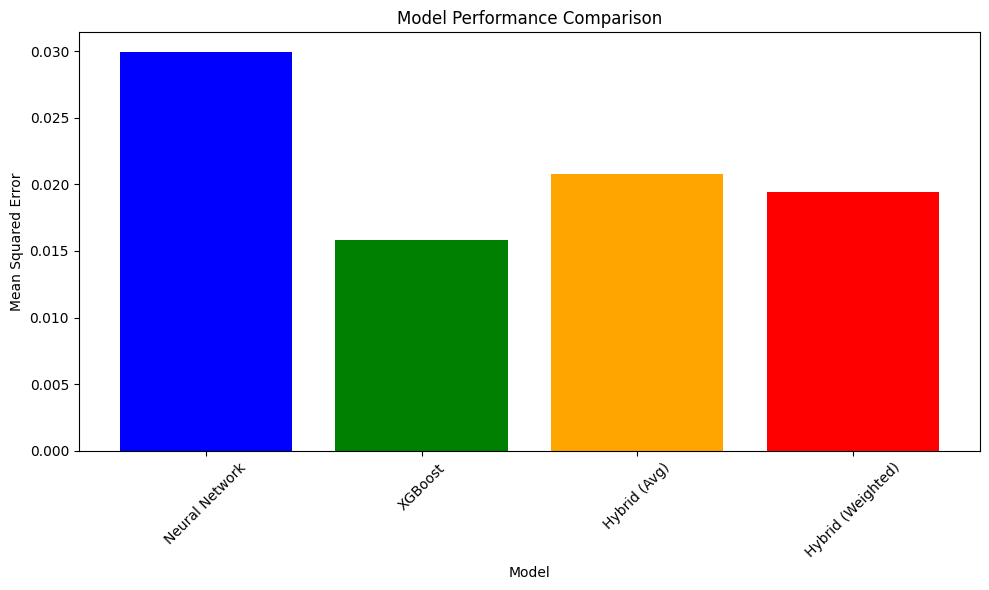

In [8]:
import matplotlib.pyplot as plt

# Assuming mse values are stored
mse_values = {
    "Neural Network": mean_squared_error(y_test, nn_preds),
    "XGBoost": mean_squared_error(y_test, xgb_preds),
    "Hybrid (Avg)": hybrid_mse,
    "Hybrid (Weighted)": weighted_hybrid_mse
}

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(mse_values.keys(), mse_values.values(), color=["blue", "green", "orange", "red"])
plt.xlabel("Model")
plt.ylabel("Mean Squared Error")
plt.title("Model Performance Comparison")
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot
plt.savefig("model_performance_comparison.png")